# analyze_fit_us_data.ipynb

Analyze the curves that [fit_us_data.ipynb](./fit_us_data.ipynb) fit to the COVID-19 time series.

Inputs:
* `outputs/us_counties_curves.csv`: Curves generated by [fit_us_data.ipynb](./fit_us_data.ipynb)
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

In [2]:
# Read in the CSV file and apply the saved type information
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")

# Read column type metadata
with open(meta_file) as f:
    curves_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
curves_meta["Date"] = "object"

curves_vertical = (
    pd
    .read_csv(csv_file, dtype=curves_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1001  2020-03-10  Alabama  Autauga       55869          0              False   
      2020-03-11  Alabama  Autauga       55869          0              False   
      2020-03-12  Alabama  Autauga       55869          0              False   
      2020-03-13  Alabama  Autauga       55869          0              False   
      2020-03-14  Alabama  Autauga       55869          0              False   
...                   ...      ...         ...        ...                ...   
56039 2020-06-03  Wyoming    Teton       23464        100              False   
      2020-06-04  Wyoming    Teton       23464        100              False   
      2020-06-05  Wyoming    Teton       23464        100              False   
      2020-06-06  Wyoming    Teton       23464        100              False   
      2020-06-07  Wyoming    Teton       23464        100              False   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1001  2020-03-10     1.000000    1.530274    0.000001  
      2020-03-11     1.067437    1.637682    0.000004  
      2020-03-12     1.139421    1.752601    0.000011  
      2020-03-13     1.216260    1.875551    0.000033  
      2020-03-14     1.298280    2.007088    0.000097  
...                       ...         ...         ...  
56039 2020-06-03   135.835323  100.684639  100.732145  
      2020-06-04   143.915306  100.693249  100.839270  
      2020-06-05   152.475917  100.700755  100.945268  
      2020-06-06   161.545744  100.707299  101.050104  
      2020-06-07   171.155078  100.713005  101.153744  

[102240 rows x 8 columns]

In [3]:
# Name of the column that bgfs.ipynb analyzed
ts_col_name = "Confirmed"
outlier_col_name = ts_col_name + "_Outlier"
metadata_cols = ["State", "County", "Population"]

In [4]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
curves_vertical[outlier_col_name] = curves_vertical[outlier_col_name].astype(np.int8)
curves_vertical

State   County  Population  Confirmed  Confirmed_Outlier  \
FIPS  Date                                                                     
1001  2020-03-10  Alabama  Autauga       55869          0                  0   
      2020-03-11  Alabama  Autauga       55869          0                  0   
      2020-03-12  Alabama  Autauga       55869          0                  0   
      2020-03-13  Alabama  Autauga       55869          0                  0   
      2020-03-14  Alabama  Autauga       55869          0                  0   
...                   ...      ...         ...        ...                ...   
56039 2020-06-03  Wyoming    Teton       23464        100                  0   
      2020-06-04  Wyoming    Teton       23464        100                  0   
      2020-06-05  Wyoming    Teton       23464        100                  0   
      2020-06-06  Wyoming    Teton       23464        100                  0   
      2020-06-07  Wyoming    Teton       23464        100                  0   

                  Exponential    Logistic   Logistic2  
FIPS  Date                                             
1001  2020-03-10     1.000000    1.530274    0.000001  
      2020-03-11     1.067437    1.637682    0.000004  
      2020-03-12     1.139421    1.752601    0.000011  
      2020-03-13     1.216260    1.875551    0.000033  
      2020-03-14     1.298280    2.007088    0.000097  
...                       ...         ...         ...  
56039 2020-06-03   135.835323  100.684639  100.732145  
      2020-06-04   143.915306  100.693249  100.839270  
      2020-06-05   152.475917  100.700755  100.945268  
      2020-06-06   161.545744  100.707299  101.050104  
      2020-06-07   171.155078  100.713005  101.153744  

[102240 rows x 8 columns]

In [5]:
# Collapse each time series or mask down to a single cell
curves, dates = util.collapse_time_series(curves_vertical, [
    ts_col_name, outlier_col_name,
    "Exponential", "Logistic", "Logistic2"])
curves

,State,County,Population,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,
1001,Alabama,Autauga,55869,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.06743667 1.13942103 1.216...,[ 1.53027366 1.637682 1.75260063 1.875...,[1.35934480e-06 3.95126287e-06 1.14850803e-05 3...
1003,Alabama,Baldwin,223234,[ 0 0 0 0 0 1 1 1 1 1 2 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.07193664 1.14904815 1.231...,[ 4.79113015 5.21896668 5.6842725 6.190...,[ 0.74542393 0.86984921 1.01480498 1.183...
1005,Alabama,Barbour,24686,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.06326131 1.1305246 1.202...,[ 1.63175416 1.73464954 1.84400358 1.960...,[ 0.31702038 0.3652318 0.42014581 0.482...
1011,Alabama,Bullock,10101,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 0.51590099 0.55375887 0.59439484 0.638...,[9.12517153e-06 1.14673861e-05 1.44107915e-05 1...,[ 0.69412835 0.73825613 0.78513732 0.834...
1013,Alabama,Butler,19448,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.07538129 1.15644492 1.243...,[9.99167813e-02 1.13921177e-01 1.29887866e-01 1...,[6.99329566e-02 7.94432795e-02 9.02438875e-02 1...
...,...,...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,[ 0 0 1 1 3 3 3 4 5 12 15 2...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.08251305e+00 1.17183450e+00 1...,[ 48.68020709 50.6573152 52.71118078 54.844...,[4.79670195e-01 6.65954499e-01 9.23781231e-01 1...
55139,Wisconsin,Winnebago,171907,[ 0 0 0 0 1 1 3 3 5 5 5 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.06971034 1.14428022 1.224...,[ 2.09863068 2.237404 2.38532163 2.542...,[5.20450577e-03 1.50184556e-02 4.30269411e-02 1...
56013,Wyoming,Fremont,39261,[ 0 0 0 0 1 1 1 8 8 8 9 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.07100523 1.1470522 1.228...,[ 3.08082732 3.33431352 3.60841644 3.904...,[ 5.97287795 6.34588633 6.74052277 7.157...


In [6]:
# Read in the parameters of the curves in `curves`
params_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
params = pd.read_csv(params_data_file).set_index("FIPS", verify_integrity=True)
params

,State,County,Population,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,0.065260,0.000000,463.716007,0.068068,83.894759,467.264844,5.064251,83.809424,473.375738,0.067269,84.505892,7.980338,8.980338
1003,Alabama,Baldwin,223234,0.069467,0.000000,300.057335,0.086983,47.378273,313.435482,0.154971,39.330242,310.684446,0.092354,53.258985,33.639231,44.597922
1005,Alabama,Barbour,24686,0.061341,0.000000,404.019256,0.061406,89.694843,397.087955,0.126574,89.925239,403.556861,0.059744,89.925181,10.000224,19.999884
1011,Alabama,Bullock,10101,0.070814,9.346118,241.668813,0.228470,74.810773,456.227148,0.068733,84.881219,216.265955,0.456937,74.967375,0.000000,69.691565
1013,Alabama,Butler,19448,0.072675,0.000000,446.942453,0.131200,64.067028,273.522147,0.322629,55.325285,546.914119,0.121808,67.624931,0.000000,90.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,0.079285,0.000000,1243.932358,0.041467,77.190744,1097.784346,10.000000,89.869464,1566.166662,0.034049,90.000000,10.691827,14.047549
55139,Wisconsin,Winnebago,171907,0.067388,0.000000,682.344808,0.064235,90.000000,701.499463,10.000000,89.996582,682.165704,0.064199,90.000000,0.000000,0.000000
56013,Wyoming,Fremont,39261,0.068598,0.000000,316.936642,0.079877,57.885964,418.882042,0.225065,55.384750,411.420582,0.047727,71.736428,0.000000,37.356211


In [7]:
# Create a dataframe of R^2 (coefficient of determination) values
# to measure how well each curve fit each series.

def compute_r_squared(colname):
    return [
        metrics.r2_score(
            curves.loc[fips][ts_col_name], curves.loc[fips][colname])
            for fips in curves.index
    ]

stats = curves[metadata_cols].copy()
stats["Exp_R^2"] = compute_r_squared("Exponential")
stats["Log_R^2"] = compute_r_squared("Logistic")
stats["Log2_R^2"] = compute_r_squared("Logistic2")
stats

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1001,Alabama,Autauga,55869,0.935384,0.996537,0.996715
1003,Alabama,Baldwin,223234,0.251080,0.993949,0.998939
1005,Alabama,Barbour,24686,0.951225,0.993697,0.994809
1011,Alabama,Bullock,10101,0.944497,0.986360,0.998699
1013,Alabama,Butler,19448,0.808439,0.997711,0.999328
...,...,...,...,...,...,...
55133,Wisconsin,Waukesha,404198,0.275842,0.977052,0.993480
55139,Wisconsin,Winnebago,171907,0.950595,0.981594,0.981625
56013,Wyoming,Fremont,39261,0.559262,0.995299,0.997420


In [8]:
# Compute some summary statistics of our summary statistics
stats[["Exp_R^2", "Log_R^2", "Log2_R^2"]].describe()

,Exp_R^2,Log_R^2,Log2_R^2
count,1136.000000,1136.000000,1136.000000
mean,0.310946,0.983304,0.990097
std,0.534848,0.021010,0.034031
min,-2.050767,0.693353,0.380901
25%,0.026570,0.979853,0.994184
50%,0.413025,0.989336,0.997520
75%,0.723062,0.994237,0.998710
max,0.996431,0.999568,0.999984


In [9]:
# Based on the stats above, it looks like R^2 >= 0.99 is a useful cutoff
# for "the curve fits the data"
r2_thresh = 0.99

# Let's see how many counties fit our curves at least that well.
print(f"""\
 Exp_R^2: {(stats['Exp_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
 Log_R^2: {(stats['Log_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
Log2_R^2: {(stats['Log2_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
"""
)

 Exp_R^2: 4 of 1136 counties have R^2 >= 0.99
 Log_R^2: 529 of 1136 counties have R^2 >= 0.99
Log2_R^2: 949 of 1136 counties have R^2 >= 0.99



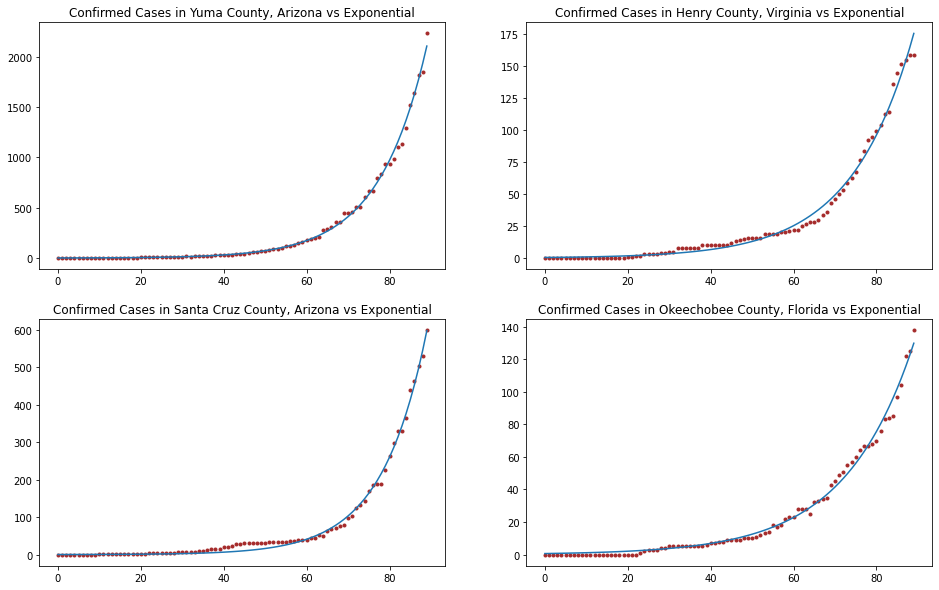

In [10]:
# The R^2 metrics divide the time series into several groups. Let's look at
# examples of each of these groups in turn.
#
# Show some example time series for which a single exponential curve
# has R^2 above 0.99
util.graph_examples(curves, ts_col_name, {"Exponential": curves["Exponential"]},
                    mask=stats['Exp_R^2'] >= r2_thresh)

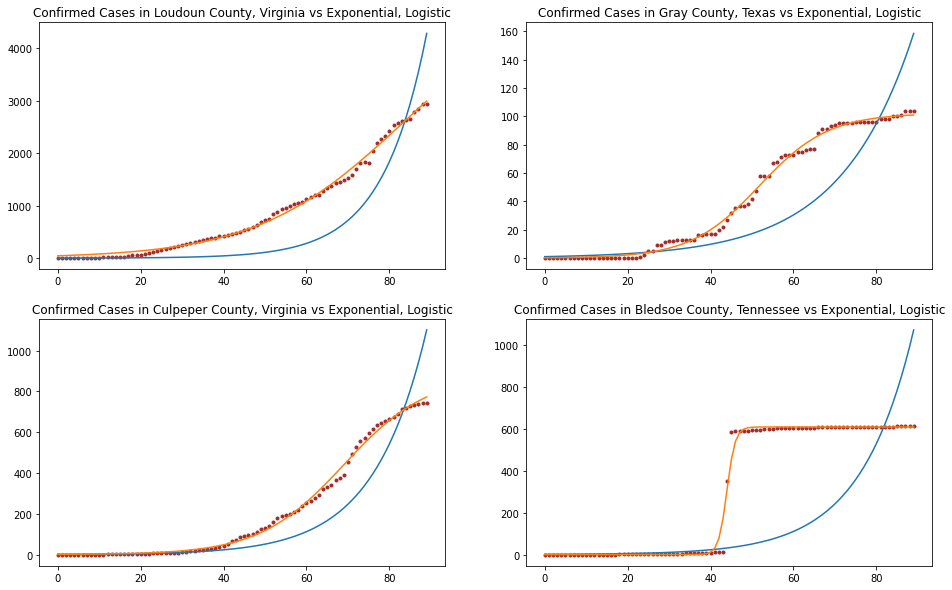

In [11]:
# Let's look at some examples where logistic growth (with a single
# instance of the logistic function) produces a good fit, while an
# exponential growth model does not.
mask = (stats['Log_R^2'] >= r2_thresh) & (stats['Exp_R^2'] < 0.95)
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=mask)

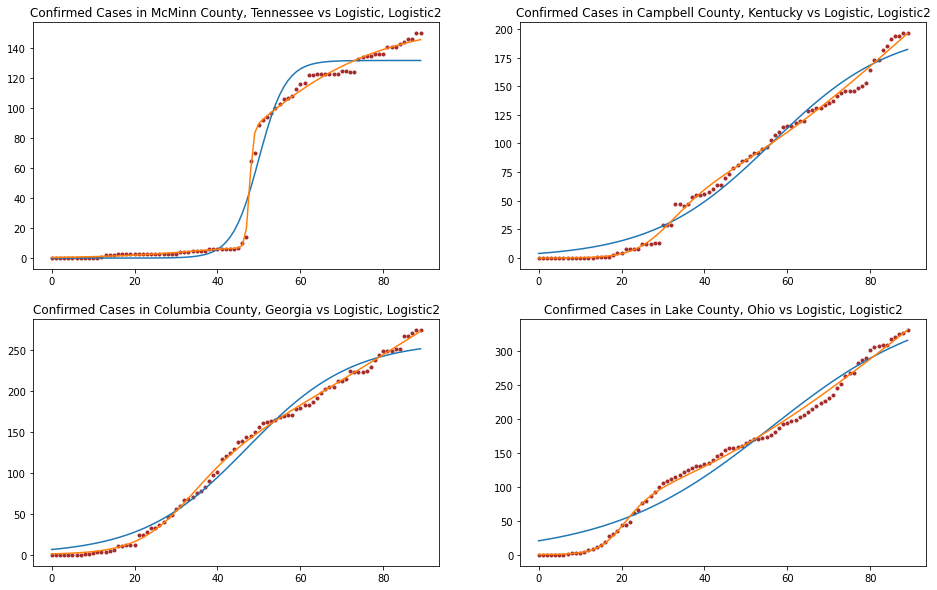

In [12]:
# Look at cases where a mixture of two logistic growth models explains
# the data better than a single logistic growth model.
mask = stats['Log2_R^2'] - stats['Log_R^2'] >= 0.01
#graph_examples(mask, {"Logistic": logistic, "Logistic2": logistic2}, num_to_pick=10)
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=mask)

In [13]:
# Many of these dual-logistic curves have low values for the rate of the
# second logistic function.
# Across the entire data set, what models have logistic rate2 near zero?
small_rate2_mask = (stats['Log2_R^2'] >= r2_thresh) & (params["Log2_Rate2"] < 5e-2)
params[small_rate2_mask][metadata_cols + [c for c in params.columns if c.startswith("Log2")]]

,State,County,Population,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,
1015,Alabama,Calhoun,113605,2.226261e+02,3.025202,56.074345,220.309459,0.038496,57.004203,19.371899,22.117022
1017,Alabama,Chambers,33254,0.000000e+00,0.000000,36.263480,739.149805,0.010423,90.000000,22.722878,27.294189
1021,Alabama,Chilton,44428,2.238331e+02,10.000000,88.742903,226.175371,0.029680,90.000000,17.971886,22.870388
1031,Alabama,Coffee,52342,4.074972e+02,10.000000,53.245529,409.275406,0.038095,76.119014,29.282836,33.944390
1055,Alabama,Etowah,102268,6.705797e-10,10.000000,59.130534,334.824223,0.048233,58.124601,19.606598,22.606703
...,...,...,...,...,...,...,...,...,...,...,...
55079,Wisconsin,Milwaukee,945726,1.773487e+03,0.177226,25.813094,25971.361259,0.000000,89.998164,74.984969,88.693705
55117,Wisconsin,Sheboygan,115340,1.390904e+02,0.042418,89.999894,209.818428,0.029439,89.999969,17.628239,19.570037
55127,Wisconsin,Walworth,103868,8.871469e+02,4.472878,72.352907,898.108643,0.033532,90.000000,31.593580,39.205981


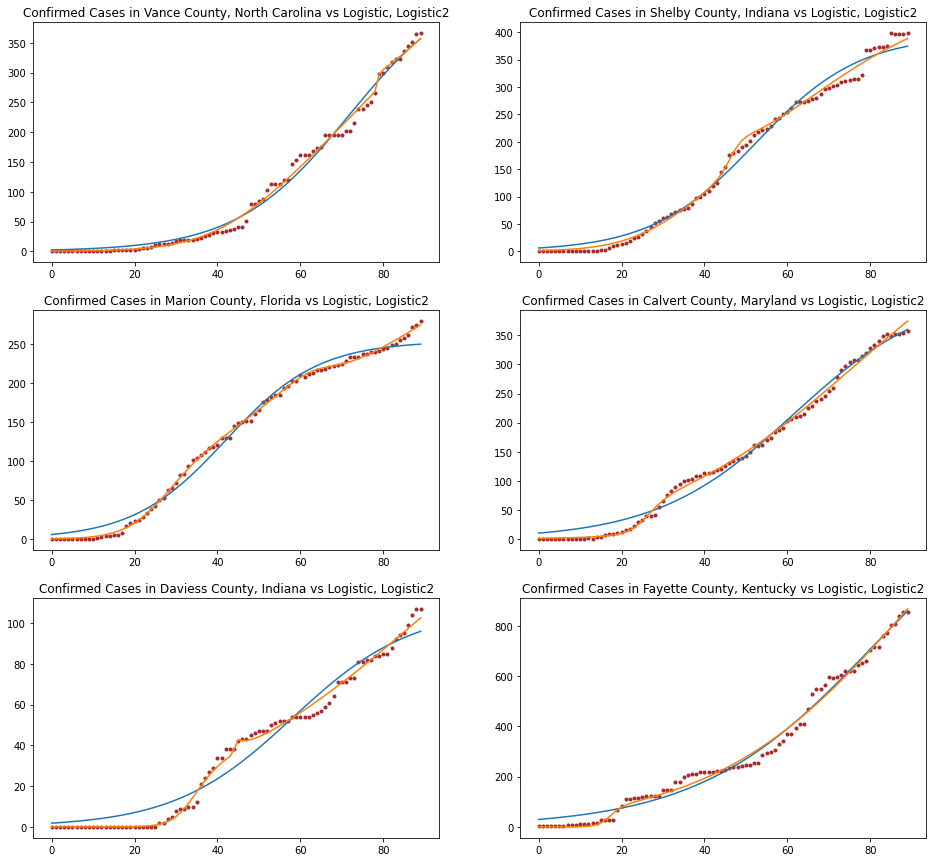

In [14]:
# Show some examples of these cases where Rate2 is small
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=small_rate2_mask,
                    num_to_pick=6)

In [35]:
# What about counties for which the rate for the single-logistic-curve fit
# is large?
large_rate_mask = (
    (stats['Log_R^2'] >= r2_thresh) 
    & (params["Log_Rate"] > 2e-1))
params[large_rate_mask][metadata_cols + [c for c in params.columns 
                                         if (c.startswith("Log")
                                             and not c.startswith("Log2"))]]

,State,County,Population,Log_Max,Log_Rate,Log_Offset
FIPS,,,,,,
5079,Arkansas,Lincoln,13024,947.780192,0.330447,43.713952
12077,Florida,Liberty,8354,208.353516,0.636177,57.099677
15003,Hawaii,Honolulu,974563,409.836773,0.204388,23.476519
16013,Idaho,Blaine,23021,498.524918,0.306990,22.313903
18017,Indiana,Cass,37689,1557.176608,0.384586,48.097147
19013,Iowa,Black Hawk,131228,1687.897962,0.206028,48.433893
19099,Iowa,Jasper,37185,259.605502,0.205466,49.767008
20103,Kansas,Leavenworth,81758,1089.172515,0.209192,54.266938
21083,Kentucky,Graves,37266,156.628674,0.232913,43.486126


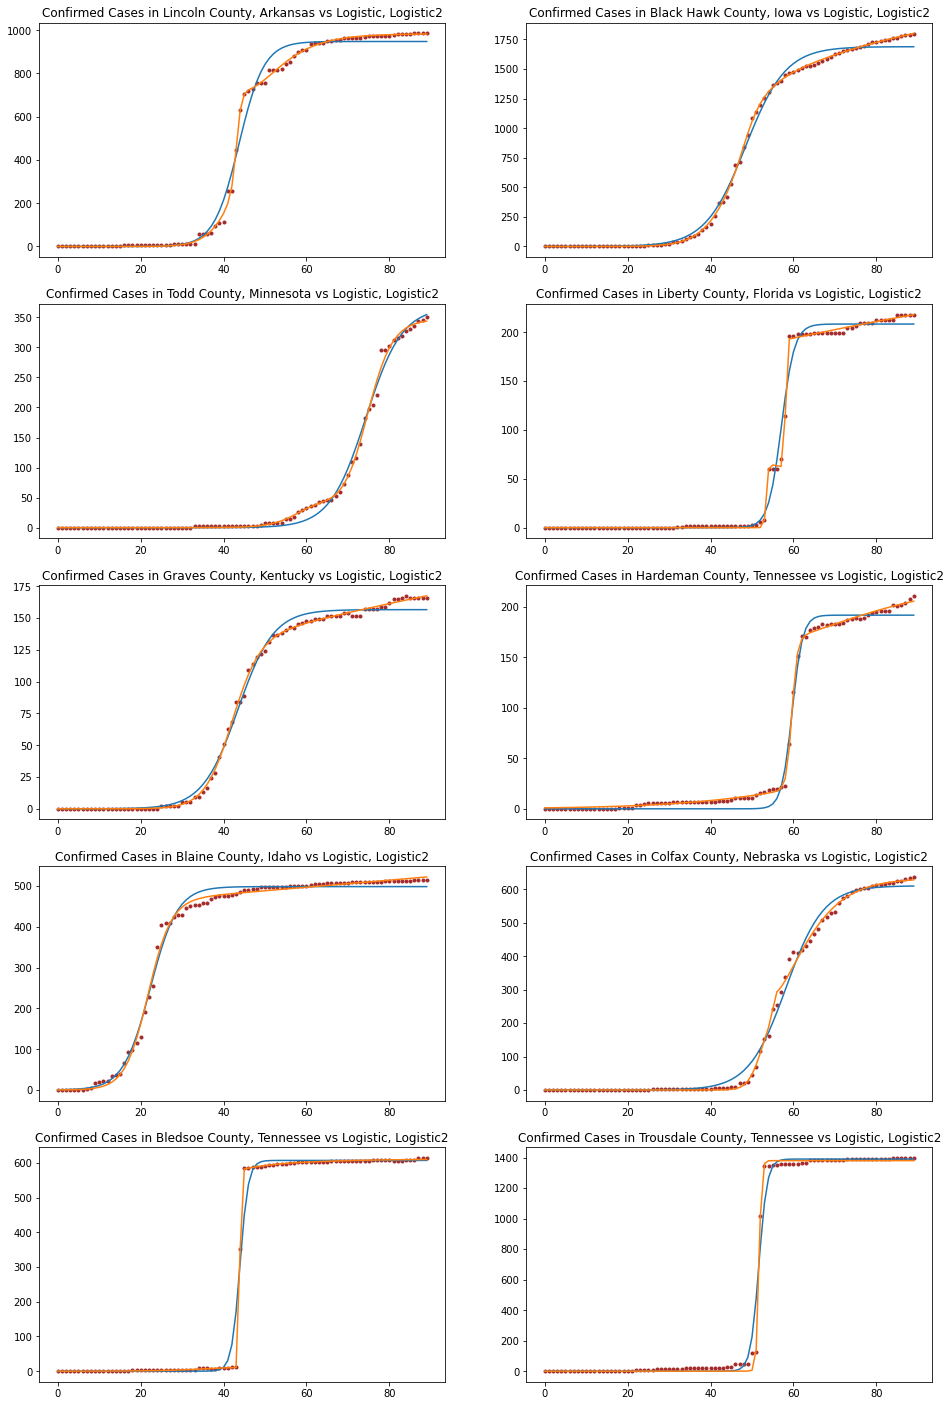

In [36]:
# Show some examples of these cases where Rate is large
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=large_rate_mask,
                    num_to_pick=10)

In [53]:
# What about counties for which the logistic curve fit is currently
# in the early phases of logistic growth
early_mask = (
    (stats['Log_R^2'] >= r2_thresh) & (params["Log_Offset"] > 80))
params[early_mask][metadata_cols + [c for c in params.columns 
                                    if (c.startswith("Log") and not c.startswith("Log2"))]]

,State,County,Population,Log_Max,Log_Rate,Log_Offset
FIPS,,,,,,
1001,Alabama,Autauga,55869,463.716007,0.068068,83.894759
1005,Alabama,Barbour,24686,404.019256,0.061406,89.694843
1025,Alabama,Clarke,23622,261.864068,0.063483,81.004837
1045,Alabama,Dale,49172,234.005040,0.063216,83.812035
1051,Alabama,Elmore,81209,783.068450,0.057196,86.734580
1065,Alabama,Hale,14651,373.089494,0.059450,86.046112
1101,Alabama,Montgomery,226486,3970.908670,0.064765,87.390358
4023,Arizona,Santa Cruz,46498,1207.022232,0.123283,90.000000
4027,Arizona,Yuma,213787,4160.901765,0.111702,89.974640


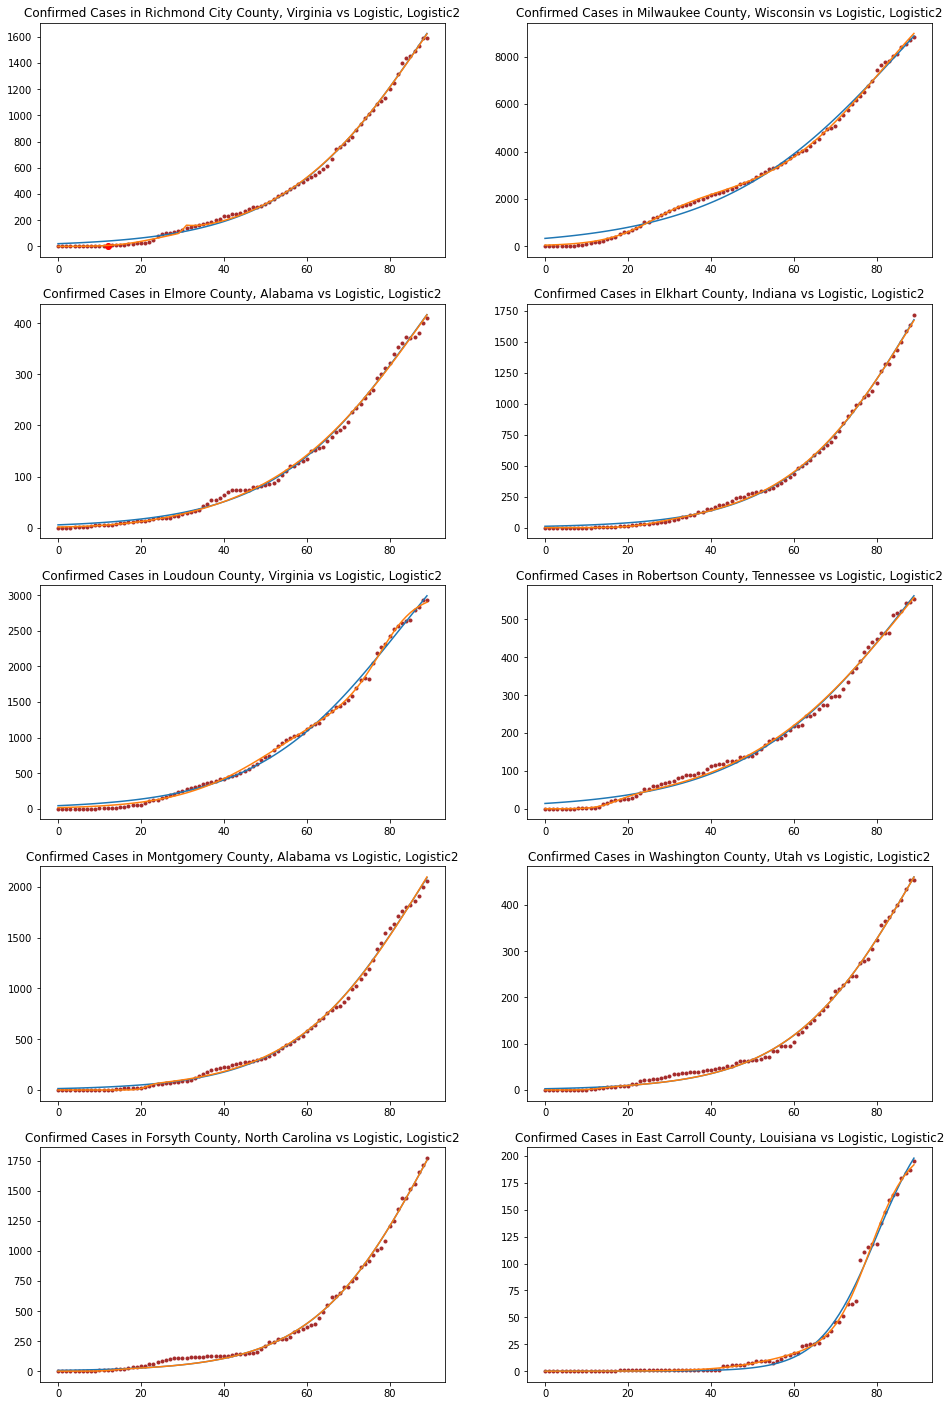

In [54]:
# Graphs of counties for which the logistic curve fit is currently
# in the early phases of logistic growth
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=early_mask,
                    num_to_pick=10)

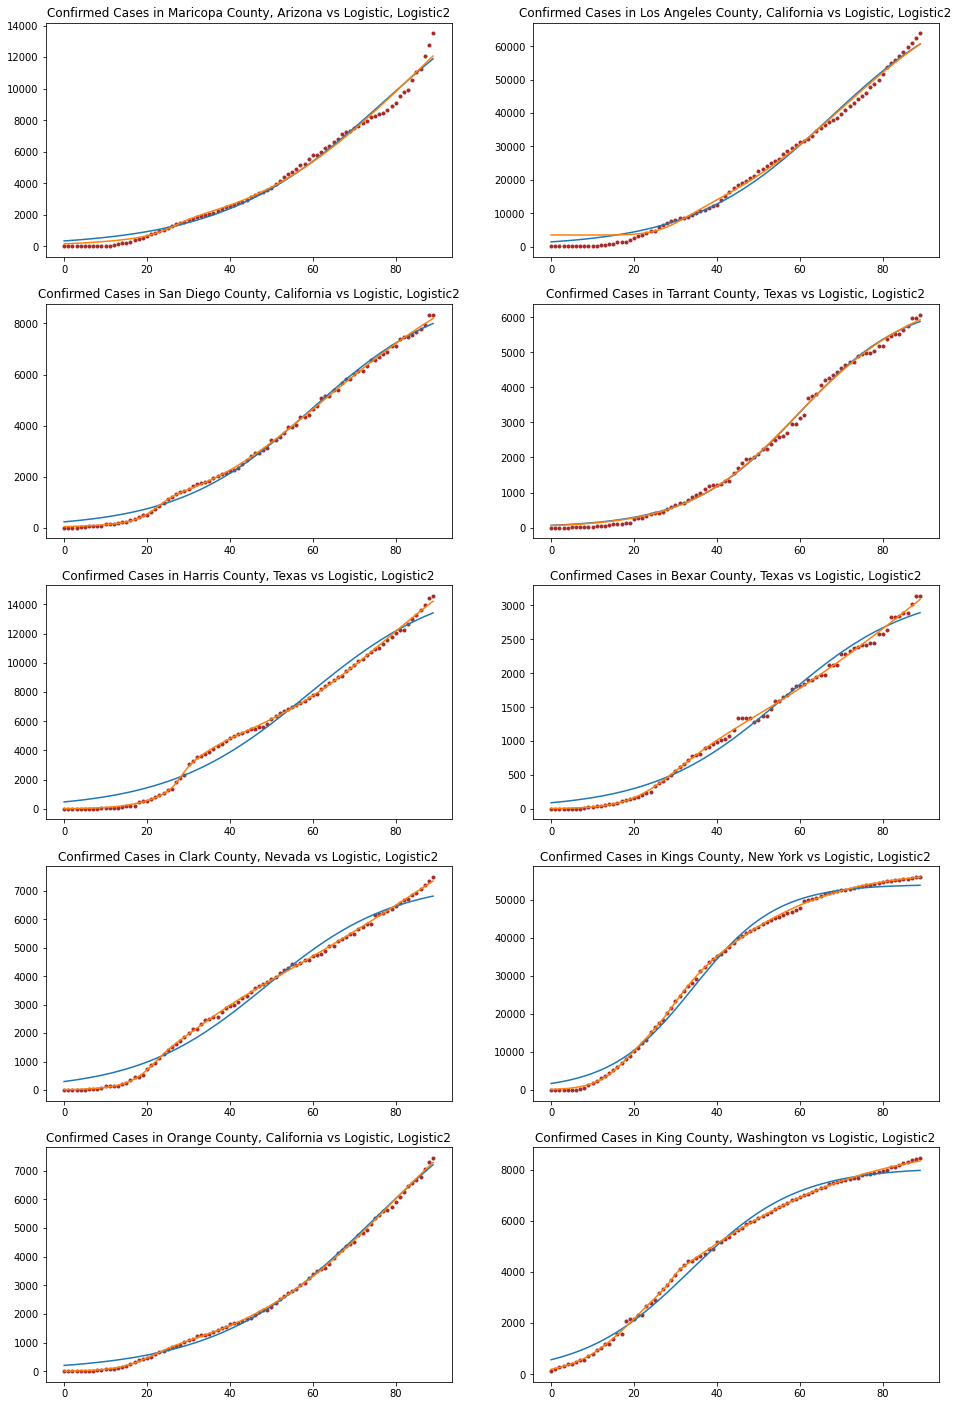

In [17]:
# What about populous counties?
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=curves["Population"] > 2e6,
                    num_to_pick=10)

In [18]:
# What time series are *not* explained by any of our curves?
non_fitting_mask = (stats["Exp_R^2"] < 0.99) & (stats["Log_R^2"] < 0.99) & (stats["Log2_R^2"] < 0.99)
stats[non_fitting_mask]

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1043,Alabama,Cullman,83768,0.794350,0.909857,0.915591
1083,Alabama,Limestone,98915,0.575291,0.946213,0.969039
1103,Alabama,Morgan,119679,0.932933,0.968874,0.964155
1109,Alabama,Pike,33114,0.852953,0.983909,0.988507
1111,Alabama,Randolph,22722,0.408169,0.984707,0.989321
...,...,...,...,...,...,...
55039,Wisconsin,Fond du Lac,103403,0.679373,0.983342,0.984277
55055,Wisconsin,Jefferson,84769,0.815530,0.978312,0.983570
55089,Wisconsin,Ozaukee,89221,0.108812,0.947372,0.988803


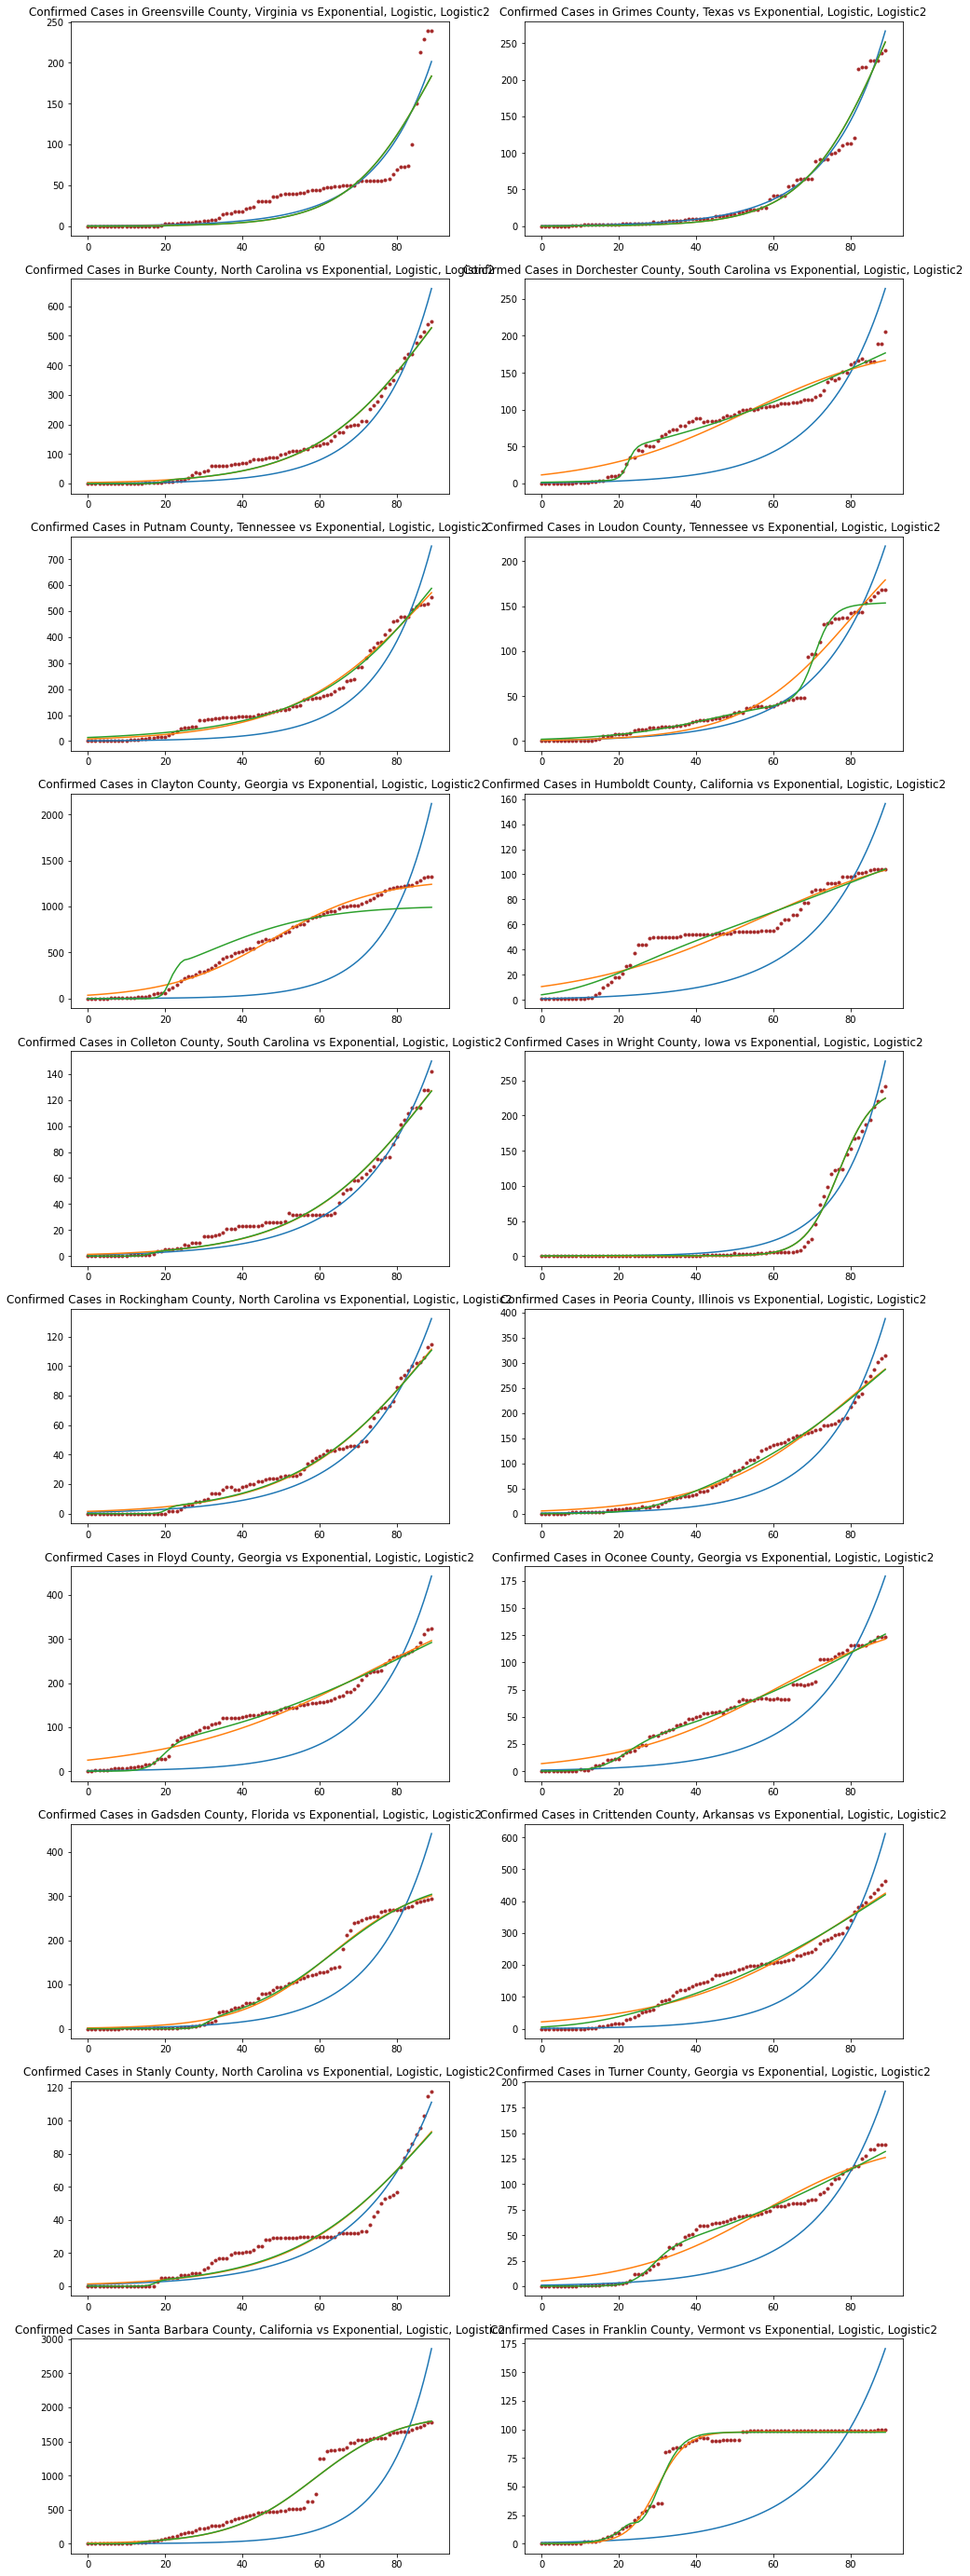

In [19]:
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=non_fitting_mask,
                    num_to_pick=20)